# Train a reinforcement model to play hit stationary target

## Import libiaries

In [1]:
# Import libraries for SpaceShooter game
import pygame
import random
from enum import Enum
import time
import os
from random import randint
import numpy as np

# Import libraries for the Model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import libraries for plot function 
import matplotlib.pyplot as plt
from IPython import display

# Import libraries for the Agent
from collections import deque

pygame 2.1.2 (SDL 2.0.18, Python 3.9.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Initialise settings 

In [2]:
pygame.font.init()
pygame.mixer.init()

WIDTH, HEIGHT = 900, 500
WIN = pygame.display.set_mode((WIDTH, HEIGHT))
BORDER = pygame.Rect(WIDTH//2 - 5, 0, 10, HEIGHT)
HEALTH_FONT = pygame.font.SysFont('comicsans', 40)
WINNER_FONT = pygame.font.SysFont('comicsans', 100)
FPS = 60

## Set colours

In [3]:
BLACK = (0, 0, 0)
RED = (255, 0, 0)
YELLOW = (255, 255, 0)
PURPLE = (200, 0, 200)

## Initialise physics


In [4]:
VEL = 25
BULLET_VEL = 10
SPACESHIP_WIDTH, SPACESHIP_HEIGHT = 55, 40

## Initialise images and sounds

In [5]:
YELLOW_HIT = pygame.USEREVENT + 1
RED_HIT = pygame.USEREVENT + 2

# Heart image
HEART_IMAGE = pygame.image.load(os.path.join('Assets', 'heart.png')).convert_alpha()
HEART = pygame.transform.scale(HEART_IMAGE, (40, 40))

# Yellow spaceShip image
YELLOW_SPACESHIP_IMAGE = pygame.image.load(os.path.join('Assets', 'spaceship_yellow.png'))
YELLOW_SPACESHIP = pygame.transform.rotate(pygame.transform.scale(YELLOW_SPACESHIP_IMAGE, (SPACESHIP_WIDTH, SPACESHIP_HEIGHT)), 90)

# Red spaceship image
RED_SPACESHIP_IMAGE = pygame.image.load(os.path.join('Assets', 'spaceship_red.png'))
RED_SPACESHIP = pygame.transform.rotate(pygame.transform.scale(RED_SPACESHIP_IMAGE, (SPACESHIP_WIDTH, SPACESHIP_HEIGHT)), 270)

# Backround image
SPACE = pygame.transform.scale(pygame.image.load(os.path.join('Assets', 'space_background_2.jpg')), (WIDTH, HEIGHT))

# Game sounds
BULLET_HIT_SOUND = pygame.mixer.Sound('Assets/Grenade+1.mp3')
BULLET_FIRE_SOUND = pygame.mixer.Sound('Assets/Gun+Silencer.mp3')

In [6]:
class Action(Enum):
    UP = 1
    DOWN = 2
    FIRE = 3
    NOTHING = 4

## Build enviroment

In [7]:
class SpaceShooter:

    def __init__(self):
        #Init display
        pygame.display.set_caption("SpaceShooterAI")
        self.BORDER = pygame.Rect(WIDTH//2 - 5, 0, 10, HEIGHT)
        self.clock = pygame.time.Clock()
        self.reset()
          
    def reset(self):
        # Reset game state
        self.frame_iteration = 0
        # Spaceships
        self.red = pygame.Rect(700, 230, SPACESHIP_WIDTH, SPACESHIP_HEIGHT)
        self.yellow = pygame.Rect(100, 230, SPACESHIP_WIDTH, SPACESHIP_HEIGHT)
        # Bullets
        self.yellow_bullet = None
        self.red_bullet = None
        self.last_shot = 0
        self.YELLOW_BULLET_FLAG = 0
        self.RED_BULLET_FLAG = 0
        self.hits = 0
        # Health
        self.red_health = 100
        self.yellow_health = 1
        # Red movement
        self.action = Action.NOTHING
        self.lock_move = 10
        self.count = self.lock_move
        self.move = 0
        
    def step(self, action):
        self.frame_iteration += 1
        # Collect user input and perform action 
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()
            
        # [UP, DOWN, FIRE, NOTHING]
        if np.array_equal(action, [1, 0, 0]) and self.yellow.y - VEL > 0: # UP
            self.action = Action.UP
            self.yellow.y -= VEL
        elif np.array_equal(action, [0, 1, 0]) and self.yellow.y + VEL + self.yellow.height < HEIGHT - 15: # DOWN
            self.action = Action.DOWN
            self.yellow.y += VEL
        elif np.array_equal(action, [0, 0, 1]) and self.YELLOW_BULLET_FLAG == 0 and time.time() - self.last_shot >= 0.1: # FIRE
            self.action = Action.FIRE
            self.yellow_bullet = pygame.Rect(self.red.x, self.yellow.y + self.yellow.height//2, 10, 5)
            self.YELLOW_BULLET_FLAG = 1
            self.last_shot = time.time()
            # BULLET_FIRE_SOUND.play() uncomment if you want sound :)
        
        # Check if game is over 
        game_over = False 
        reward = 0
        # Yellow bullet
        if self.yellow_bullet != None:
            self.yellow_bullet.x += BULLET_VEL
            if self.red.colliderect(self.yellow_bullet):
                reward = 10
                self.red_health -= 1
                self.hits += 1
                self.yellow_bullet = None
                self.YELLOW_BULLET_FLAG = 0
                return game_over, self.red_health, reward
            elif self.yellow_bullet.x > WIDTH:
                #self.yellow_bullet = None
                #self.YELLOW_BULLET_FLAG = 0
                reward = -10
                game_over = True
                return game_over, self.hits, reward
        
        # Red bullet
        if self.red_bullet != None:
            self.red_bullet.x -= BULLET_VEL
            if self.yellow.colliderect(self.red_bullet):
                reward = -10
                game_over = True
                #game_over = False
                self.red_bullet = None
                self.RED_BULLET_FLAG = 0
                return game_over, self.hits, reward
            elif self.red_bullet.x <= 0:
                self.red_bullet = None
                self.RED_BULLET_FLAG = 0
        
        # Yellow wins
        if self.red_health <= 0:
            reward = 10
            game_over = True
            self.winner_text = "TriBlaster beast!"
            self.winner_colour = YELLOW
            self.draw_winner()
            return game_over, self.hits, reward
        
        # punishment for not doing anything
        if self.frame_iteration > 100*(self.hits + 1) :
            reward = -10
            game_over = True
            return game_over, self.hits, reward
        
        # Red Spaceship baisc AI
        # movement
        self.move_direction = random.randint(-1,1)  
        if self.count == self.lock_move:
            self.move = self.move_direction 
        self.count -= 1 
        if self.count == 0:
            self.count = self.lock_move
        if self.move == -1 and self.red.y - VEL > 0:  # UP
            self.red.y -= VEL
        if self.move == 1 and self.red.y + VEL + self.red.height < HEIGHT-15:  # DOWN
            self.red.y += VEL 
        # shooting 
        if self.RED_BULLET_FLAG == 0:
            self.red_bullet = pygame.Rect(self.red.x, self.red.y + self.red.height//2, 10, 5)
            self.RED_BULLET_FLAG = 1
            #BULLET_FIRE_SOUND.play()
    
        # Update UI and Clock 
        self.draw_window()
        self.clock.tick(FPS)
        return game_over, self.hits, reward 
        
    #Render
    def draw_window(self):
        WIN.blit(SPACE, (0, 0))
        pygame.draw.rect(WIN, PURPLE, BORDER)
        
        # Draw spaceship health
        self.red_health_text = HEALTH_FONT.render(str(self.red_health), 1, RED)
        self.yellow_health_text = HEALTH_FONT.render(str(self.yellow_health), 1, RED)
        
        # Draw score
        WIN.blit(HEART, (WIDTH - 150, 17))
        WIN.blit(self.red_health_text, (WIDTH - 100, 10))
        
        # Draw Spaceships
        WIN.blit(YELLOW_SPACESHIP, (self.yellow.x, self.yellow.y))
        WIN.blit(RED_SPACESHIP, (self.red.x, self.red.y))

        # Draw bullets
        if self.yellow_bullet != None:
            pygame.draw.rect(WIN, YELLOW, self.yellow_bullet)  
        if self.red_bullet != None:
            pygame.draw.rect(WIN, RED, self.red_bullet)
        
        # Update display
        pygame.display.update()   
        
    def draw_winner(self):
        draw_text = WINNER_FONT.render(self.winner_text, 1, self.winner_colour)
        WIN.blit(draw_text, (WIDTH/2 - draw_text.get_width() /2, HEIGHT/2 - draw_text.get_height()/2))
        pygame.display.update()
        pygame.time.delay(500)

## Create the model used to train the Agent

In [8]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name='spaceshooter_record.pth'):
        model_folder_path = './SpaceShooter_model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)
        
    def save_250(self, file_name='spaceshooter_250.pth'):
        model_folder_path = './SpaceShooter_model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

    def save_500(self, file_name='spaceshooter_500.pth'):
        model_folder_path = './SpaceShooter_model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)
        
    def save_1000(self, file_name='spaceshooter_1000.pth'):
        model_folder_path = './SpaceShooter_model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        # (n, x)

        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new
    
        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

## Create Plot function to display training data

In [9]:
plt.ion()

def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...TriBlaster please be patient :)')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)

## Train an Agent to play the SpaceShooter game 

<Figure size 432x288 with 0 Axes>

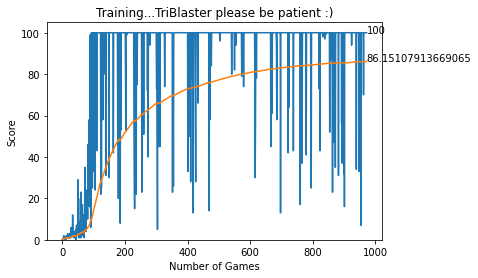

Game 973 Score 100 Record: 100
Action.UP


KeyboardInterrupt: 

In [10]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000

# Learning rate
LR = 0.001 

class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, game):
        # yellow spaceship center
        yellow_center = game.yellow.y + game.yellow.height//2
        
        # red spaceship center
        red_center = game.red.y + game.red.height//2
        
        # red bullet center
        if game.red_bullet != None:
            red_bullet_center = game.red_bullet.y + 2.5
        else:
            red_bullet_center = game.red.y + game.red.height//2 + 2.5
        
        # center of yellow_spaceship in next after moving
        # Up
        if game.yellow.y-VEL > 0:
            yellow_center_up = yellow_center - VEL
        else:
            yellow_center_up = yellow_center
        # Down
        if game.yellow.y + VEL + game.yellow.height < HEIGHT - 15:
            yellow_center_down = yellow_center + VEL 
        else:
            yellow_center_down = yellow_center
        
        # Position of yellow_spaceship in next after taking action
        # Up
        if game.yellow.y-VEL > 0:
            yellow_up = pygame.Rect(game.yellow.x, game.yellow.y - VEL, SPACESHIP_WIDTH, SPACESHIP_HEIGHT)
        else:
            yellow_up = pygame.Rect(game.yellow.x, game.yellow.y, SPACESHIP_WIDTH, SPACESHIP_HEIGHT)
        # Down
        if game.yellow.y + VEL + game.yellow.height < HEIGHT - 15:
            yellow_down = pygame.Rect(game.yellow.x, game.yellow.y + VEL, SPACESHIP_WIDTH, SPACESHIP_HEIGHT)
        else:
            yellow_down = pygame.Rect(game.yellow.x, game.yellow.y, SPACESHIP_WIDTH, SPACESHIP_HEIGHT)
        
        # Action
        action_up = game.action == Action.UP
        action_down = game.action == Action.DOWN
        action_fire = game.action == Action.FIRE 
        
        # Test red bullet
        if game.red_bullet != None:
            test_red_bullet_current = pygame.Rect(game.red_bullet.x, game.red_bullet.y, 10, 5)
            test_red_bullet = pygame.Rect(game.red_bullet.x-BULLET_VEL, game.red_bullet.y, 10, 5)
        else:
            test_red_bullet_current = pygame.Rect(700, 0, 10, 5)
            test_red_bullet = pygame.Rect(700, 0, 10, 5)
        
        # Test yellow bullet
        test_yellow_bullet = pygame.Rect(game.red.x, game.yellow.y + game.yellow.height//2, 10, 5)
        
        # State 
        state = [
            # Checks for shooting red spaceship
            # If yellow spaceship fires from current position will it hit the red spaceship
            game.red.colliderect(test_yellow_bullet),
                        
            # Direction of the red bullet from yellow spaceship
            yellow_center < red_center,  # red spaceship is below yellow spaceship
            yellow_center > red_center,   # red spaceship is above yellow spaceship
            
            # Will yellow spaceship be closer to red spaceship after moving
            abs(yellow_center_up - red_center) < abs(game.yellow.y - red_center), # After moving up
            abs(yellow_center_down - red_center) < abs(game.yellow.y - red_center), # After moving down
            
            # Current action
            action_up,
            action_down,
            action_fire,
            
            # Checks for dodging red bullet
            # Will yellow be hit by red bullet in current position
            game.yellow.colliderect(test_red_bullet),
            
            # Will yellow be hit by red bullet after moving 
            (yellow_up.colliderect(test_red_bullet) or yellow_up.colliderect(test_red_bullet_current)), # After moving up
            (yellow_down.colliderect(test_red_bullet) or yellow_down.colliderect(test_red_bullet_current)), # After moving down
            ]
         
        return np.array(state, dtype=int)
    
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        
    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SpaceShooter()
    
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)
        
        # perform move and get new state
        done, score, reward = game.step(final_move)
        state_new = agent.get_state(game)

        # train short memory
        agent.train_short_memory(state_old, final_move, reward, state_new, done)

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        if done:
            # train long memory, plot result
            agent.n_games += 1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()
                
            # Save model after a certain amount of games
            if agent.n_games == 250:
                agent.model.save_250()
            if agent.n_games == 500:
                agent.model.save_500()
            if agent.n_games == 1000:
                agent.model.save_1000()

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)
                            
            print('Game', agent.n_games, 'Score', score, 'Record:', record)
            print(game.action)

            game.reset()
            
if __name__ == '__main__':
    train()